In [ ]:
# GPU 여부 확인
import torch
print("GPU 사용 가능 여부:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU 이름:", torch.cuda.get_device_name(0))

# 필요한 라이브러리 설치
!pip install adamp tqdm

GPU 사용 가능 여부: True
GPU 이름: Tesla T4


In [ ]:
# 데이터 & 모델 정의
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam
from adamp import AdamP
from tqdm import tqdm
import matplotlib.pyplot as plt

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 6

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# 학습/평가 함수
def train_and_evaluate(optimizer_name):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "Adam":
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    else:
        optimizer = AdamP(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=1e-4)

    train_losses, train_accs = [], []
    for epoch in range(NUM_EPOCHS):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"{optimizer_name} Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)
        print(f"{optimizer_name} Epoch [{epoch+1}/{NUM_EPOCHS}] → Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    # 테스트 정확도
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f"{optimizer_name} 최종 테스트 정확도: {test_acc:.2f}%\n")

    return train_losses, train_accs, test_acc

Adam Epoch [1/6] → Loss: 0.6117, Acc: 78.00%


Adam Epoch [2/6] → Loss: 0.3964, Acc: 85.82%


Adam Epoch [3/6] → Loss: 0.3407, Acc: 87.84%


Adam Epoch [4/6] → Loss: 0.3066, Acc: 89.06%


Adam Epoch [5/6] → Loss: 0.2831, Acc: 89.91%


Adam Epoch [6/6] → Loss: 0.2639, Acc: 90.51%
Adam 최종 테스트 정확도: 90.66%



AdamP Epoch [1/6] → Loss: 0.6042, Acc: 78.18%


AdamP Epoch [2/6] → Loss: 0.3846, Acc: 86.15%


AdamP Epoch [3/6] → Loss: 0.3337, Acc: 87.99%


AdamP Epoch [4/6] → Loss: 0.3005, Acc: 89.30%


AdamP Epoch [5/6] → Loss: 0.2768, Acc: 89.93%


AdamP Epoch [6/6] → Loss: 0.2597, Acc: 90.59%
AdamP 최종 테스트 정확도: 90.08%



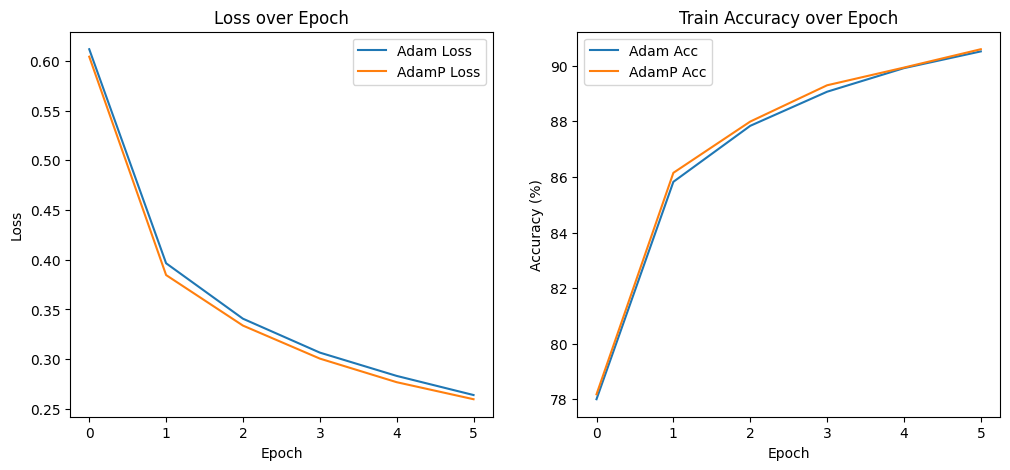

 최종 테스트 정확도 → Adam: 90.66%, AdamP: 90.08%


In [ ]:
#  Adam과 AdamP 비교 실행
adam_loss, adam_acc, adam_test = train_and_evaluate("Adam")
adamp_loss, adamp_acc, adamp_test = train_and_evaluate("AdamP")

# 결과 시각화
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(adam_loss, label="Adam Loss")
plt.plot(adamp_loss, label="AdamP Loss")
plt.title("Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(adam_acc, label="Adam Acc")
plt.plot(adamp_acc, label="AdamP Acc")
plt.title("Train Accuracy over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

print(f" 최종 테스트 정확도 → Adam: {adam_test:.2f}%, AdamP: {adamp_test:.2f}%")